Kevin Huang
DA 320 Capstone Portfolio Project: MongoDB Machine Learning Midterm

In [20]:
import json
import re
import pymongo
from pymongo import MongoClient

# Load a credentials file that has your connection string with username and password (need to make a text file containing connection string beforehand)
with open('Z:\\JSON\\credentials.json') as f:
    data = json.load(f)

    # Make a variable to read you credentials file 
    secret_key = data['key']

# Print out how many characters your secret key is from your credentials file
print(f"My secret key is {len(secret_key)} characters in length.")

My secret key is 12 characters in length.


In [21]:
import pymongo
import certifi

# Use your connection string here 
mongo_connection_string = data['mongoconnstring']

# Connect to the database using known good certificates
client = pymongo.MongoClient(mongo_connection_string, tlsCAFile=certifi.where())

# Fetch your database from the mongo server by using the database word for word (I made a typo and put DBA instead DA but not a huge deal)
db = client['DBA320Database']

# Read the collections within your database (similar to SQL tables)
all_collections = db.list_collection_names()

# Lists out the collections within your database and what version of MongoDB you are using
print(f"Using MongoDB version {client.server_info()['version']}.")
print(f"This database has the collections {all_collections}")

Using MongoDB version 6.0.6.
This database has the collections ['MetacriticMovies', 'Superhero']


In [22]:
import pandas as pd
from tabulate import tabulate

# Retrieves all records that have the year 2020 in release date from both collections
superhero_query = { "release_date": { "$regex": ".*2020.*" } }
super_cursor = db["Superhero"].find(superhero_query)
metacritic_query = { "release_date": { "$regex": ".*2020.*" } }
meta_cursor = db["MetacriticMovies"].find(metacritic_query)

# Convert the data into a Pandas dataframe
superhero = pd.DataFrame(super_cursor)
metacritic = pd.DataFrame(meta_cursor)

# Removes 0 for starting number and makes it 1 to make it easier to count rows
superhero.index += 1
metacritic.index += 1

# Show the first 5 rows of both collections
print("Superhero IMDB DataFrame:")
print(tabulate(superhero.head(5), headers='keys', tablefmt='pretty', stralign='left'))

print("Metacritic Movies DataFrame:")
print(tabulate(metacritic.head(5), headers='keys', tablefmt='pretty', stralign='left'))

# Merge the two collections
merged_data = pd.merge(superhero, metacritic, how="inner", on="title")

Superhero IMDB DataFrame:
+---+--------------------------+---------+---------------+---------+-------------+--------+-------------+--------------+-------------+-----------------+-------------+-------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------+--------------------------------------------------------------------------------+------------------------------------------------------------------------------+
|   | _id                      | id      | title         | runtime | user_rating | votes  | mpaa_rating | release_date | budget      | opening_weekend | gross_sales | genres                              | cast                                                                                                                                                                                | director  

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

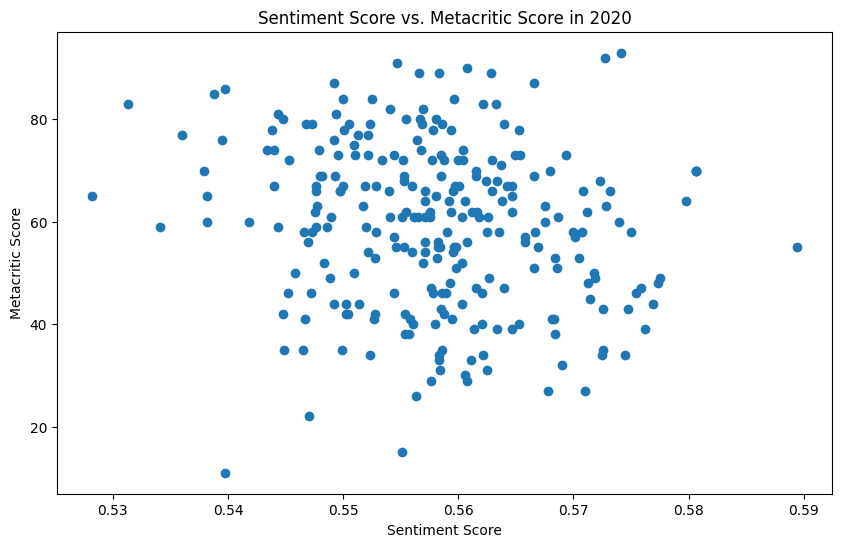

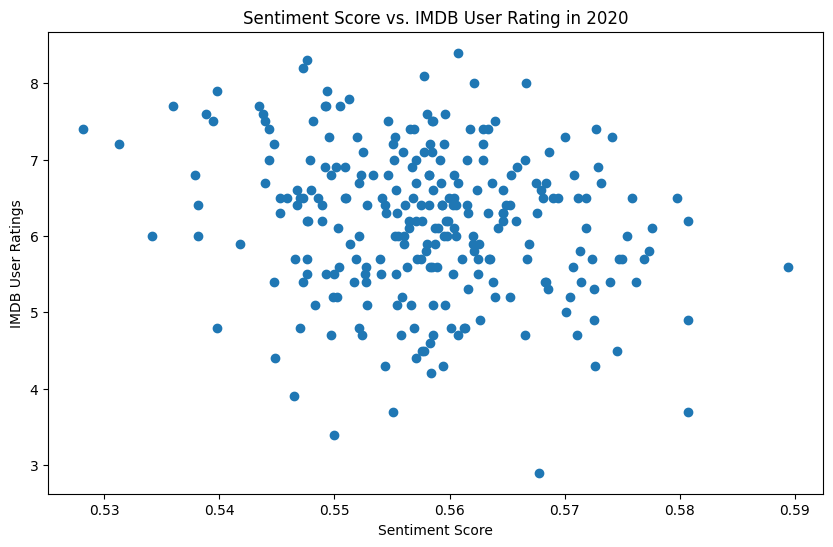

In [32]:
import pandas as pd
import transformers
import matplotlib.pyplot as plt
import numpy as np

# Get the distilbert sentiment analysis classifier pipeline in
classifier = transformers.pipeline("sentiment-analysis", model="distilbert-base-uncased")

# Perform sentiment analysis on movie descriptions
sentiment_scores = []
for description in merged_data["description"]:
    result = classifier(description)[0]
    sentiment_scores.append(result["score"])

# Add the sentiment scores as a new column in the movie dataset
merged_data["sentiment_score"] = sentiment_scores

# Plot sentiment scores against metacritic scores
plt.figure(figsize=(10, 6))
plt.scatter(merged_data["sentiment_score"], merged_data["score"])
plt.xlabel("Sentiment Score")
plt.ylabel("Metacritic Score")
plt.title("Sentiment Score vs. Metacritic Score in 2020")
plt.show()

# Plot sentiment scores against IMDB user ratings
plt.figure(figsize=(10, 6))
plt.scatter(merged_data["sentiment_score"], merged_data["user_rating"])
plt.xlabel("Sentiment Score")
plt.ylabel("IMDB User Ratings")
plt.title("Sentiment Score vs. IMDB User Rating in 2020")
plt.show()

With variance between runs it seems to stay within the boundaries of 0.5 and 0.6. Sentiments seem to be grouped nearer towards 0.5 and gets less frequent the higher it goes. IMDB ratings and Metacritic scores seem to be similar even though one is out of 100 and the other is 10. If you put it up to scale it has a similar distribution. The grouping for both ratings are grouped in the center between 50 and 80 and 5 and 8. Movies seem average more or less for 2020 as few made it higher and 8 or 80 and sentiments seem to be in the middle.



Title                                            Predicted Genre    Actual Genre(s)
-----------------------------------------------  -----------------  ---------------------------------------------------------------------
Tenet                                            fantasy            Action, Adventure, Sci-Fi, Thriller
Run                                              scary              Mystery, Thriller
Project Power                                    horror             Action, Crime, Sci-Fi, Thriller
Soul                                             fantasy            Animation, Adventure, Comedy, Drama, Family, Fantasy, Music
Monster Hunter                                   horror             Action, Adventure, Fantasy
Promising Young Woman                            scary              Crime, Drama, Mystery, Thriller
The Banker                                       gangster           Biography, Drama
Hamilton                                         biographical       Biography, D

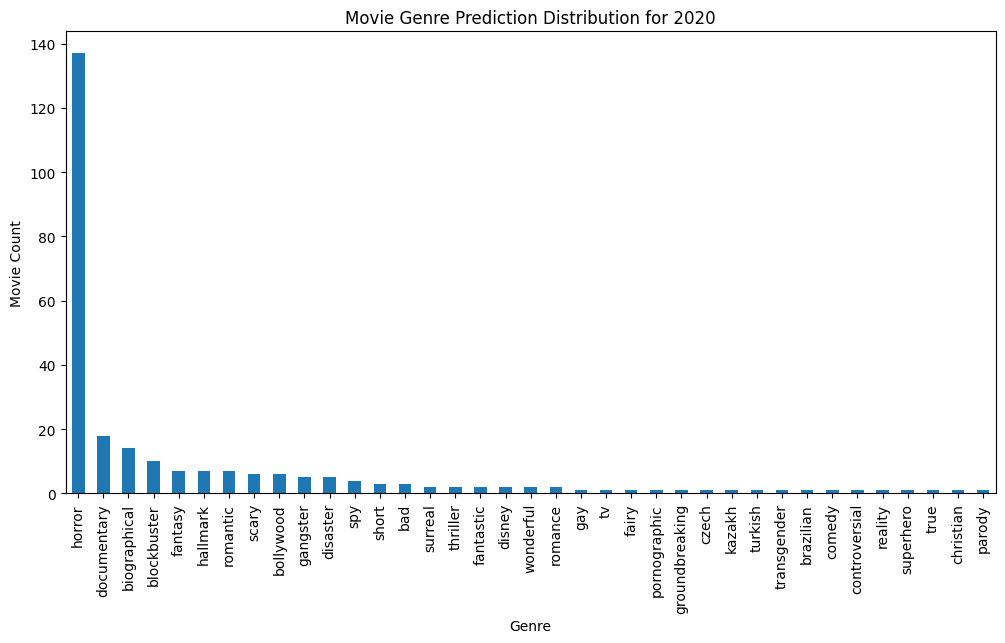

In [25]:
import transformers
import matplotlib.pyplot as plt

#Load in distilbert fill mask classifier pipeline
classifier = transformers.pipeline("fill-mask", model="distilbert-base-uncased")

# store predicted and actual genres in these lists
predicted_genres = []
actual_genres = []

# Iterates over these columns to process them
for title, description, genres in zip(merged_data["title"], merged_data["description"], merged_data["genres"]):
    # Creates a text string with title, description, and genre mask token 
    genre_prediction = classifier(f"The movie {title} which is about {description} is a [MASK] movie.")
    # Predicted genre extracted to pipeline and convereted to lowercse
    predicted_genre = genre_prediction[0]["token_str"].lower()
    # Predicted and actual genres are in its respective lists
    predicted_genres.append(predicted_genre)
    actual_genres.append(genres)
# Add these as new columns
merged_data["predicted_genre"] = predicted_genres
merged_data["actual_genre"] = actual_genres

# Display the table with predicted and actual genres for each title
table_data = []
for title, predicted_genre, actual_genre in zip(merged_data["title"], merged_data["predicted_genre"], merged_data["actual_genre"]):
    table_data.append([title, predicted_genre, actual_genre])

# Tabulate makes the table look nice :)
table_headers = ["Title", "Predicted Genre", "Actual Genre(s)"]
table = tabulate(table_data, headers=table_headers)

# Shows table columns and rows
print(table)

# Plot the distribution of top movie genres for 2020
plt.figure(figsize=(12, 6))
merged_data["predicted_genre"].value_counts().head(100).plot(kind="bar")
plt.title("Movie Genre Prediction Distribution for 2020")
plt.xlabel("Genre")
plt.ylabel("Movie Count")
plt.show()

This graph teaches you the predicted genres based on titles and descriptions from the merged dataset. There seems to be a lot of strange genres and a varied distribution. You can see the table for actual vs predicted comparison as well. The prediction data does vary slightly from to run but horror seems to dominate consistently followed by documentary and biographical during 2020.